Using device: cuda
Processing Polynomial (Degree 2) on cuda...
Processing Fully Connected NN on cuda...


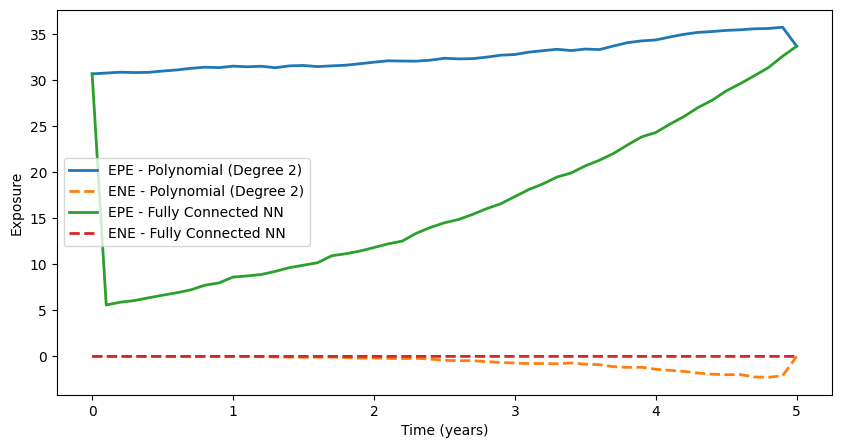

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import torch.optim as optim
import copy  # For deepcopy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class BlackScholesMC:
    def __init__(self, S0, K, r, sigma, T, num_paths, num_steps, seed=None):
        self.S0, self.K, self.r, self.sigma, self.T = S0, K, r, sigma, T
        self.num_paths, self.num_steps = num_paths, num_steps
        self.dt = T / num_steps
        self.discount_factors = np.exp(-r * self.dt)
        self.seed = seed

    def simulate_paths(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        S = np.zeros((self.num_paths, self.num_steps + 1))
        S[:, 0] = self.S0
        for t in range(1, self.num_steps + 1):
            Z = np.random.randn(self.num_paths)
            S[:, t] = S[:, t - 1] * np.exp(
                (self.r - 0.5 * self.sigma ** 2) * self.dt + self.sigma * np.sqrt(self.dt) * Z
            )
        return S

    def payoff(self, S):
        return np.maximum(S[:, -1] - self.K, 0)

class PolynomialRegressor:
    def __init__(self, degree=2):
        self.degree = degree
        self.poly = PolynomialFeatures(degree)
        self.model = LinearRegression()

    def fit(self, X, y):
        # Use full feature vector (S and t)
        X_poly = self.poly.fit_transform(X)
        self.model.fit(X_poly, y)

    def predict(self, X):
        X_poly = self.poly.transform(X)
        return self.model.predict(X_poly).squeeze()

class FullyConnectedNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, output_dim=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        ).to(device)
        self.constant = False

    def fit(self, X, y, epochs=2000, lr=0.005):
        # Only check the variability of the state variable (S in the first column)
        if np.std(X[:, 0]) < 1e-8:
            # If S is nearly constant, bypass training and store the mean target.
            self.constant = True
            self.constant_value = np.mean(y)
            return

        self.constant = False
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        y_scaled = np.log1p(y)

        X_tensor = torch.FloatTensor(X_scaled).to(device)
        y_tensor = torch.FloatTensor(y_scaled).unsqueeze(1).to(device)

        optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        criterion = nn.MSELoss()

        for _ in range(epochs):
            optimizer.zero_grad()
            loss = criterion(self.model(X_tensor), y_tensor)
            loss.backward()
            optimizer.step()
            scheduler.step()

        self.scaler = scaler

    def predict(self, X):
        if self.constant:
            return np.full((X.shape[0],), self.constant_value)

        X_scaled = self.scaler.transform(X)
        with torch.no_grad():
            pred = self.model(torch.FloatTensor(X_scaled).to(device)).cpu().numpy()
        return np.expm1(pred).squeeze()



class ExposureCalculator:
    def __init__(self, mc_engine_1st, mc_engine_2nd, regressor):
        self.mc_engine_1st = mc_engine_1st
        self.mc_engine_2nd = mc_engine_2nd
        self.regressor = regressor
        self.regressors = {}

    def first_pass(self):
        S = self.mc_engine_1st.simulate_paths()
        option_payoff = self.mc_engine_1st.payoff(S)
        pathwise_exposure = np.zeros((self.mc_engine_1st.num_paths, self.mc_engine_1st.num_steps + 1))
        pathwise_exposure[:, -1] = option_payoff
        for t in range(self.mc_engine_1st.num_steps - 1, -1, -1):
            pathwise_exposure[:, t] = pathwise_exposure[:, t + 1] * self.mc_engine_1st.discount_factors
            t_feature = np.full((self.mc_engine_1st.num_paths, 1), t / self.mc_engine_1st.num_steps)
            X_train = np.hstack((S[:, t].reshape(-1, 1), t_feature))
            # Use deepcopy to preserve regressor settings (e.g. polynomial degree or NN architecture).
            self.regressors[t] = copy.deepcopy(self.regressor)
            self.regressors[t].fit(X_train, pathwise_exposure[:, t])

    def second_pass(self):
        if not self.regressors:
            raise ValueError("first_pass() must be run before second_pass()!")
        S = self.mc_engine_2nd.simulate_paths()
        estimated_exposure = np.zeros((self.mc_engine_2nd.num_paths, self.mc_engine_2nd.num_steps + 1))
        for t in range(self.mc_engine_2nd.num_steps):
            t_feature = np.full((self.mc_engine_2nd.num_paths, 1), t / self.mc_engine_2nd.num_steps)
            X_test = np.hstack((S[:, t].reshape(-1, 1), t_feature))
            if t not in self.regressors:
                raise KeyError(f"Regressor for t={t} not found. Make sure first_pass() was executed.")
            estimated_exposure[:, t] = self.regressors[t].predict(X_test).squeeze()
        estimated_exposure[:, self.mc_engine_2nd.num_steps] = self.mc_engine_2nd.payoff(S)
        EPE = np.mean(np.maximum(estimated_exposure, 0), axis=0)
        ENE = np.mean(np.minimum(estimated_exposure, 0), axis=0)
        return EPE, ENE

if __name__ == "__main__":
    S0, K, r, sigma, T = 140, 140, 0.02, 0.2, 5
    num_paths_1st, num_paths_2nd, num_steps = 5000, 20000, 50
    seed_1st, seed_2nd = 42, 99

    mc_engine_1st = BlackScholesMC(S0, K, r, sigma, T, num_paths_1st, num_steps, seed_1st)
    mc_engine_2nd = BlackScholesMC(S0, K, r, sigma, T, num_paths_2nd, num_steps, seed_2nd)

    regressors = {
        "Polynomial (Degree 2)": PolynomialRegressor(degree=2),
        #"Polynomial (Degree 3)": PolynomialRegressor(degree=3),
        #"Fully Connected NN": FullyConnectedNN(),
        #"CNN Regressor": CNNRegressor()  # New CNN-based regressor.
    }

    results = {}
    for name, reg in regressors.items():
        print(f"Processing {name} on {device}...")
        exposure_calc = ExposureCalculator(mc_engine_1st, mc_engine_2nd, reg)
        exposure_calc.first_pass()  # Ensure first_pass() is called before second_pass()
        results[name] = exposure_calc.second_pass()

    plt.figure(figsize=(10, 5))
    for name, (EPE, ENE) in results.items():
        plt.plot(np.linspace(0, T, num_steps + 1), EPE, label=f"EPE - {name}", linewidth=2)
        plt.plot(np.linspace(0, T, num_steps + 1), ENE, linestyle="--", label=f"ENE - {name}", linewidth=2)

    plt.xlabel("Time (years)")
    plt.ylabel("Exposure")
    plt.legend()
    plt.show()
